# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 📚</h1></span>

In [1]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

import h5py
from PIL import Image
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Configuration ⚙️</h1></span>

In [2]:
CONFIG = {
    "n_fold": 5,
    "seed": 42,
    "img_size": 224,
    "model_name": "eva02_base_patch14_224.mim_in22k",
    "valid_batch_size": 64,
    "dropout_rate": 0.2,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "TTA": False,
    "save_dir": "../proc/preds",
    "EXP_NAME": "sub-isic-inference-val3-eva02-base_check"
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [3]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [4]:
ROOT_DIR = "../raw"
VAL_CSV = f'{ROOT_DIR}/train-metadata.csv'
VAL_HDF = f'{ROOT_DIR}/train-image.hdf5'
TEST_CSV = f'{ROOT_DIR}/test-metadata.csv'
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'
SAMPLE = f'{ROOT_DIR}/sample_submission.csv'

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [5]:
df = pd.read_csv(VAL_CSV)

# df_test = pd.read_csv(TEST_CSV)
# df_test["target"] = 0

# df_sub = pd.read_csv(SAMPLE)
# df_sub["target"] = 0
# df_sub

In [6]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=0)
for fold, ( _, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
    df.loc[val_ , "kfold"] = int(fold)

# df['target'] = 0 # dummy
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,4.0
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,2.0
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,1.0
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,2.0
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,1.0
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,3.0
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,0.0
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,2.0


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [7]:
class ISICDataset(Dataset):
    def __init__(self, df, file_hdf, transforms=None):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = np.array( Image.open(BytesIO(self.fp_hdf[isic_id][()])) )
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target,
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [8]:
data_transforms = {
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [9]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [10]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None, dropout_rate=CONFIG['dropout_rate']):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

        # モデルの出力サイズを取得
        if hasattr(self.model, 'num_features'):
            in_features = self.model.num_features  # num_featuresで取得するモデルが多い
        elif hasattr(self.model, 'classifier') and hasattr(self.model.classifier, 'in_features'):
            in_features = self.model.classifier.in_features  # classifierが存在する場合
        elif hasattr(self.model, 'fc') and hasattr(self.model.fc, 'in_features'):
            in_features = self.model.fc.in_features  # fcが存在する場合
        else:
            raise AttributeError("Could not find the output feature size.")

        # モデルのヘッド部分をIdentityで置き換え
        self.model.reset_classifier(0)  # timmで全結合層をリセットする簡単な方法

        # 以下のノートブックを参照した
        # https://www.kaggle.com/code/qiaoyingzhang/isic-2024-pytorch-training-baseline-swin#Modeling

        # Final fully connected layer for classification
        self.final_fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, images):
        features = self.model(images)  # ここを変更
        output = self.final_fc(features)
        return output

# CV

In [11]:
def comp_score_list(solution: list, submission: list, min_tpr: float=0.80):
    v_gt = np.abs(np.array(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [12]:
list_best_weights = [
    "../proc/models/alldata_check_val3_eva02_base_inc-pos100/fold0_pAUC0.1511_epoch24.bin",
    "../proc/models/alldata_check_val3_eva02_base_inc-pos100/fold1_pAUC0.1781_epoch24.bin",
    "../proc/models/alldata_check_val3_eva02_base_inc-pos100/fold2_pAUC0.1718_epoch24.bin",
    "../proc/models/alldata_check_val3_eva02_base_inc-pos100/fold3_pAUC0.1697_epoch24.bin",
    "../proc/models/alldata_check_val3_eva02_base_inc-pos100/fold4_pAUC0.1799_epoch24.bin"
]

In [13]:
# TTAのための関数を定義 ⇒使ってない
def apply_tta(model, image):
    outputs = []

    # オリジナル画像
    outputs.append(model(image).squeeze())

    # 水平フリップ
    outputs.append(model(torch.flip(image, dims=[3])).squeeze())

    # 垂直フリップ
    outputs.append(model(torch.flip(image, dims=[2])).squeeze())

    # 90度、180度、270度回転
    for k in [1, 2, 3]:
        outputs.append(model(torch.rot90(image, k, dims=[2,3])).squeeze())
    
    list_return = [
        torch.stack(outputs).mean(dim=0),
        torch.stack(outputs).max(dim=0)[0],
        torch.stack(outputs).min(dim=0)[0],
        torch.stack(outputs).std(dim=0)
    ]

    return list_return

In [14]:
list_df_pred = []
df_score = pd.DataFrame(columns=["pAUC80"])
for fold, weight in enumerate(list_best_weights):
    print("==="*10)
    print(f"fold {fold}")
    print("==="*10)

    df_val = df[df["kfold"]==fold]
    df_val_pred = df_val[["isic_id", "kfold"]]
    
    model = ISICModel(CONFIG['model_name'], pretrained=False)
    model.load_state_dict(torch.load(weight))
    model.to(CONFIG['device']);
    model.eval()
    ##############
    # 各foldの予測
    ##############
    val_dataset = ISICDataset(df_val, VAL_HDF, transforms=data_transforms["valid"])
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    preds = []
    with torch.inference_mode():
        bar = tqdm(enumerate(val_loader), total=len(val_loader))
        for step, data in bar:        
            images = data['image'].to(CONFIG["device"], dtype=torch.float)        
            batch_size = images.size(0)
            output = model(images).squeeze().detach().cpu().numpy()
            preds.append(output)
    df_val_pred["pred"] = np.concatenate(preds).flatten()
    list_df_pred.append(df_val_pred)
    # valスコアの計算
    score = comp_score_list(df_val["target"].to_list(), df_val_pred["pred"].to_list())
    # スコアをDataFrameに入れておく
    df_score.loc[f"fold_{fold}", "pAUC80"] = score
    print(f"pAUC80: {score:.4f}")
    
    # 不要なメモリを開放
    del model, val_dataset, val_loader
    torch.cuda.empty_cache()
    
    #############
    # testの予測
    #############
    # test_dataset = ISICDataset(df_test, TEST_HDF, transforms=data_transforms["valid"])
    # test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
    #                           num_workers=2, shuffle=False, pin_memory=True)
    # preds_test = []
    # with torch.no_grad():
    #     bar = tqdm(enumerate(test_loader), total=len(test_loader))
    #     for step, data in bar:        
    #         images = data['image'].to(CONFIG["device"], dtype=torch.float)        
    #         batch_size = images.size(0)
    #         if CONFIG["TTA"]:
    #             # with TTA
    #             outputs = apply_tta(model, images)
    #             preds_test.append(outputs[0].detach().cpu().numpy())
    #         else:
    #             # without TTA
    #             output = model(images).squeeze().detach().cpu().numpy()
    #             preds_test.append(output)
    # preds_test_all = np.concatenate(preds_test).flatten()
    # # 各foldの予測結果を順位にしてアンサンブル
    # # 順位付け（sort orderを取得）
    # rank = np.argsort(np.argsort(preds_test_all)) 
    # # パーセンタイル順位に変換
    # percentile_rank = rank / (len(rank) - 1)
    # # fold数で割ってsubのpredictionに足す
    # df_sub["target"] += percentile_rank / len(list_best_weights)
    
    # # 不要なメモリを開放
    # del model, test_dataset, test_loader
    # torch.cuda.empty_cache()

fold 0


100%|██████████| 1477/1477 [03:09<00:00,  7.81it/s]


pAUC80: 0.1514
fold 1


100%|██████████| 1344/1344 [02:52<00:00,  7.78it/s]


pAUC80: 0.1774
fold 2


100%|██████████| 1172/1172 [02:30<00:00,  7.79it/s]


pAUC80: 0.1722
fold 3


100%|██████████| 1180/1180 [02:31<00:00,  7.80it/s]


pAUC80: 0.1703
fold 4


100%|██████████| 1095/1095 [02:20<00:00,  7.79it/s]


pAUC80: 0.1773


In [15]:
df_score.loc["mean", "pAUC80"] = np.mean(df_score["pAUC80"])
df_score.loc["std", "pAUC80"] = np.std(df_score["pAUC80"])
df_score

,pAUC80
fold_0,0.151436
fold_1,0.177379
fold_2,0.172198
fold_3,0.170286
fold_4,0.177256
mean,0.169711
std,0.00872


In [16]:
df = pd.concat(list_df_pred).reset_index(drop=True)
df.to_csv(f"{CONFIG['save_dir']}/df_pred_{CONFIG['EXP_NAME']}.csv", index=False)
df

,isic_id,kfold,pred
0,ISIC_0035502,0.0,0.326115
1,ISIC_0051758,0.0,0.017215
2,ISIC_0051958,0.0,0.020168
3,ISIC_0052109,0.0,0.848928
4,ISIC_0052122,0.0,0.046321
...,...,...,...
401054,ISIC_9999086,4.0,0.521258
401055,ISIC_9999106,4.0,0.013161
401056,ISIC_9999324,4.0,0.013531
401057,ISIC_9999386,4.0,0.017888


In [17]:
df2 = pd.read_csv("../proc/models/alldata_check_val3_eva02_base_inc-pos100/df_preds_alldata_check_val3_eva02_base_inc-pos100.csv")
df2.rename(columns={
    "preds": "pred_in_cv_file"
}, inplace=True)
df = pd.merge(df, df2[["isic_id", "pred_in_cv_file"]], on=["isic_id"], how="left")
df

,isic_id,kfold,pred,pred_in_cv_file
0,ISIC_0035502,0.0,0.326115,0.326116
1,ISIC_0051758,0.0,0.017215,0.017215
2,ISIC_0051958,0.0,0.020168,0.020168
3,ISIC_0052109,0.0,0.848928,0.848928
4,ISIC_0052122,0.0,0.046321,0.046321
...,...,...,...,...
401054,ISIC_9999086,4.0,0.521258,0.521258
401055,ISIC_9999106,4.0,0.013161,0.013161
401056,ISIC_9999324,4.0,0.013531,0.013531
401057,ISIC_9999386,4.0,0.017888,0.017888


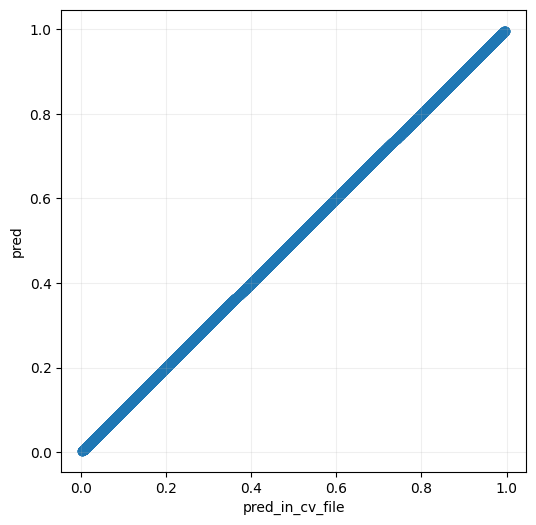

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(alpha=0.2)
ax.scatter(df["pred_in_cv_file"], df["pred"], alpha=0.5)
ax.set_xlabel("pred_in_cv_file")
ax.set_ylabel("pred")
plt.show()

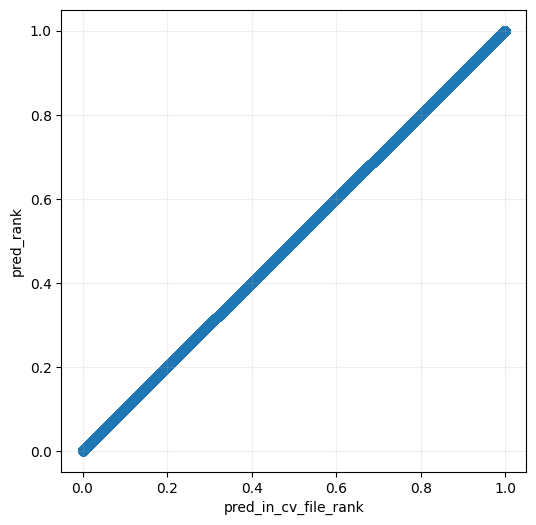

In [19]:
df["pred_in_cv_file_rank"] = df["pred_in_cv_file"].rank(pct=True)
df["pred_rank"] = df["pred"].rank(pct=True)
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(alpha=0.2)
ax.scatter(df["pred_in_cv_file_rank"], df["pred_rank"], alpha=0.5)
ax.set_xlabel("pred_in_cv_file_rank")
ax.set_ylabel("pred_rank")
plt.show()